# plotting

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram

In [18]:
# ----------------------------------------
# For plotting data
def plot_model(X_train, y_train, clf, X_trust=None, y_trust=None, title=None, 
													train_cluster_labels=None, trust_cluster_labels=None):
	
	pca = PCA(n_components=2)
	X_train_2d = pca.fit_transform(X_train)
	X_trust_2d = pca.transform(X_trust)

	# X = np.zeros((10000,2))
	# a = np.linspace(0,1,100)
	# b = np.linspace(0,1,100)
	# e, d = np.meshgrid(a, b)
	# X[:,0] = np.reshape(e,(10000,))
	# X[:,1] = np.reshape(d,(10000,))

	# Z = clf.predict(X)
	# probs = clf.predict_proba(K)[:, 1].reshape(e.shape)

	plt.figure()

	# Put the result into a color plot
	# Z = Z.reshape(e.shape)
	# plt.contour(e, d, probs, levels=[0.5])

	# Plot clusters
	if train_cluster_labels is not None:
		if trust_cluster_labels is not None:
			cluster_labels = np.concatenate([train_cluster_labels,trust_cluster_labels])
			X = np.vstack([X_train_2d, X_trust_2d])
			plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, marker='o', s=80)
		else:
			plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=train_cluster_labels, marker='o', s=80)

	# Plot the training points
	plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=plt.cm.Paired, marker='.')
	
	# Plot the trusted points
	if X_trust_2d is not None:
		plt.scatter(X_trust_2d[:, 0], X_trust_2d[:, 1], c=y_trust, cmap=plt.cm.Paired, marker='X')

	if title is not None:
		plt.title(str(title))

	plt.xlabel('x1')
	plt.ylabel('x2')
	plt.draw()

Plotting Dendrogram...
https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py

In [19]:
def plot_dendrogram(model, **kwargs):
    
    plt.title('Hierarchical Clustering Dendrogram')
    
    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
    plt.show()

# GermanLoan

In [20]:
import csv
from sklearn.cluster import KMeans
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics.pairwise import rbf_kernel
import sys
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [21]:
# read dataset
col_names = ['Checking Status', 'Duration','Credit History', 'Credit Amt','Purpose', 
              'Saving acc', 'Present emp since', 'Installment Rate',
             'Personal Status', 'Age', 'Other debtors', 'Present Residence since', 'Property',
              'Other installment plans', 'Housing', 'Existing credits',
             'Job', 'Num People', 'Telephone', 'Foreign Worker','a','b','c','d','Approval Status']

numerical = ['Duration','Credit Amt','Age']

print("Reading dataset...")
all_data = pd.read_csv("germanloan.csv", names=col_names)
print(all_data.shape)

n = all_data.shape[0]
X = all_data[all_data.columns.difference(['Approval Status'])]
y = all_data['Approval Status']
print(X.shape,y.shape)

Reading dataset...
(1000, 25)
(1000, 24) (1000,)


In [22]:
all_data.head(30)

,Checking Status,Duration,Credit History,Credit Amt,Purpose,Saving acc,Present emp since,Installment Rate,Personal Status,Age,...,Existing credits,Job,Num People,Telephone,Foreign Worker,a,b,c,d,Approval Status
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,1
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,2
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,1
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,1
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,2
5,4,36,2,91,5,3,3,4,4,35,...,0,0,1,0,0,0,0,1,0,1
6,4,24,2,28,3,5,3,4,2,53,...,0,0,1,0,0,1,0,0,1,1
7,2,36,2,69,1,3,3,2,3,35,...,0,1,1,0,1,0,0,0,0,1
8,4,12,2,31,4,4,1,4,1,61,...,0,0,1,0,0,1,0,1,0,1
9,2,30,4,52,1,1,4,2,3,28,...,1,0,1,0,0,1,0,0,0,2


In [23]:
# Set 1=good, -1=bad in y
y[y==2] = -1

In [24]:
# scaler = StandardScaler()
# X.loc[:,['Duration','Credit Amt']] = scaler.fit_transform(X.loc[:,['Duration','Credit Amt']].astype('float64'))

In [25]:
# partition dataset on the basis of age, threshold = 25
X_y = X[X['Age']<=25]
X_o = X[X['Age']>25]
y_y = y[X['Age']<=25]
y_o = y[X['Age']>25]
print(X_y.shape, X_o.shape)

(190, 24) (810, 24)


In [26]:
X_y.head(2)

,Age,Checking Status,Credit Amt,Credit History,Duration,Existing credits,Foreign Worker,Housing,Installment Rate,Job,...,Present Residence since,Present emp since,Property,Purpose,Saving acc,Telephone,a,b,c,d
1,22,2,60,2,48,0,0,1,2,0,...,1,2,1,1,3,0,1,0,0,1
10,25,2,13,2,12,1,1,1,1,0,...,1,2,1,1,2,0,0,0,0,1


In [27]:
# Remove age as a feature
del X_y['Age']
del X_o['Age']

print(X_y.shape, X_o.shape)

(190, 23) (810, 23)


In [28]:
# Converting to numpy arrays
X_young = X_y.values
X_old = X_o.values
y_young = y_y.values
y_old = y_o.values

In [29]:
print(X_young.shape, X_old.shape)

(190, 23) (810, 23)


In [30]:
# Random arrays for partitioning into A,B,C datasets
np.random.seed(123)
young = np.random.permutation(np.arange(X_young.shape[0]))
old = np.random.permutation(np.arange(X_old.shape[0]))

In [31]:
# --------------------------------------------------------------
print("Creating datasets A, B and C...")
# Create dataset A (trusted dataset)
X_A = np.concatenate((X_young[young[:20],:],X_old[old[:20],:]))
y_A = np.concatenate((y_young[young[:20]],y_old[old[:20]]))
# print(X_A.shape,y_A.shape)

# Create dataset B (buggy dataset)
X_B = np.concatenate((X_young[young[20:190],:],X_old[old[20:190],:]))
y_B = np.concatenate((y_young[young[20:190]],y_old[old[20:190]]))
# print(X_B.shape,y_B.shape)

# Create dataset C (ground truth)
X_C = X_old[old[190:],:]
y_C = y_old[old[190:]]
# print(X_C.shape,y_C.shape)

Creating datasets A, B and C...


In [32]:
# --------------------------------------------------------------
print("Training Model on dataset C...")

# the learner is hard coded to be logistic regression
lam = 5e-3	# L2 regularization weight of learner

# Training model f* on dataset C
clf = LogisticRegression(solver='lbfgs', C=lam)

clf = AdaBoostClassifier()


clf.fit(X_C, y_C)
y_C_pred = clf.predict(X_C)

print("Creating trusted labels for dataset A...")
y_A_pred = clf.predict(X_A)

print("Number of label changes made in Dataset A to make it trusted: %d"%np.count_nonzero(y_A-y_A_pred)),"\n"
y_A = y_A_pred

Training Model on dataset C...
Creating trusted labels for dataset A...
Number of label changes made in Dataset A to make it trusted: 11


# The Gower Function
https://sourceforge.net/projects/gower-distance-4python/files/

In [41]:
from scipy.spatial import distance 
from sklearn.utils import validation
from sklearn.metrics import pairwise
from scipy.sparse import issparse

In [42]:
def check_pairwise_arrays(X, Y, precomputed=False, dtype=None):
    X, Y, dtype_float = pairwise._return_float_dtype(X, Y)

    warn_on_dtype = dtype is not None
    estimator = 'check_pairwise_arrays'
    if dtype is None:
        dtype = dtype_float

    if Y is X or Y is None:
        X = Y = validation.check_array(X, accept_sparse='csr', dtype=dtype,
                            warn_on_dtype=warn_on_dtype, estimator=estimator)
    else:
        X = validation.check_array(X, accept_sparse='csr', dtype=dtype,
                        warn_on_dtype=warn_on_dtype, estimator=estimator)
        Y = validation.check_array(Y, accept_sparse='csr', dtype=dtype,
                        warn_on_dtype=warn_on_dtype, estimator=estimator)

    if precomputed:
        if X.shape[1] != Y.shape[0]:
            raise ValueError("Precomputed metric requires shape "
                             "(n_queries, n_indexed). Got (%d, %d) "
                             "for %d indexed." %
                             (X.shape[0], X.shape[1], Y.shape[0]))
    elif X.shape[1] != Y.shape[1]:
        raise ValueError("Incompatible dimension for X and Y matrices: "
                         "X.shape[1] == %d while Y.shape[1] == %d" % (
                             X.shape[1], Y.shape[1]))

    return X, Y


In [43]:

# Vectorized Version
def gower_distances(X, Y=None, feature_weight=None, categorical_features=None):
    """Computes the gower distances between X and Y

    Gower is a similarity measure for categorical, boolean and numerical mixed
    data.

    
    Parameters
    ----------
    X : array-like, or pandas.DataFrame, shape (n_samples, n_features)

    Y : array-like, or pandas.DataFrame, shape (n_samples, n_features)

    feature_weight :  array-like, shape (n_features)
        According the Gower formula, feature_weight is an attribute weight.

    categorical_features: array-like, shape (n_features)
        Indicates with True/False whether a column is a categorical attribute.
        This is useful when categorical atributes are represented as integer
        values. Categorical ordinal attributes are treated as numeric, and must
        be marked as false.
        
        Alternatively, the categorical_features array can be represented only
        with the numerical indexes of the categorical attribtes.

    Returns
    -------
    similarities : ndarray, shape (n_samples, n_samples)

    Notes
    ------
    The non-numeric features, and numeric feature ranges are determined from X and not Y.
    No support for sparse matrices.

    """
    
    if issparse(X) or issparse(Y):
        raise TypeError("Sparse matrices are not supported for gower distance")
        
    y_none = Y is None
    
    
    # It is necessary to convert to ndarray in advance to define the dtype
    if not isinstance(X, np.ndarray):
        X = np.asarray(X)

    array_type = np.object
    # this is necessary as strangelly the validator is rejecting numeric
    # arrays with NaN
    if  np.issubdtype(X.dtype, np.number) and (np.isfinite(X.sum()) or np.isfinite(X).all()):
        array_type = type(np.zeros(1,X.dtype).flat[0])
    
    X, Y = check_pairwise_arrays(X, Y, precomputed=False, dtype=array_type)
    
    n_rows, n_cols = X.shape
    
    if categorical_features is None:
        categorical_features = np.zeros(n_cols, dtype=bool)
        for col in range(n_cols):
            # In numerical columns, None is converted to NaN,
            # and the type of NaN is recognized as a number subtype
            if not np.issubdtype(type(X[0, col]), np.number):
                categorical_features[col]=True
    else:          
        categorical_features = np.array(categorical_features)
    
    
    #if categorical_features.dtype == np.int32:
    if np.issubdtype(categorical_features.dtype, np.int):
        new_categorical_features = np.zeros(n_cols, dtype=bool)
        new_categorical_features[categorical_features] = True
        categorical_features = new_categorical_features
    
#     print(categorical_features)
  
    # Categorical columns
    X_cat =  X[:,categorical_features]
    
    # Numerical columns
    X_num = X[:,np.logical_not(categorical_features)]
    ranges_of_numeric = None
    max_of_numeric = None
    
        
    # Calculates the normalized ranges and max values of numeric values
    _ ,num_cols=X_num.shape
    ranges_of_numeric = np.zeros(num_cols)
    max_of_numeric = np.zeros(num_cols)
    for col in range(num_cols):
        col_array = X_num[:, col].astype(np.float32) 
        max = np.nanmax(col_array)
        min = np.nanmin(col_array)
     
        if np.isnan(max):
            max = 0.0
        if np.isnan(min):
            min = 0.0
        max_of_numeric[col] = max
        ranges_of_numeric[col] = (1 - min / max) if (max != 0) else 0.0


    # This is to normalize the numeric values between 0 and 1.
    X_num = X_num.astype(float)
    max_of_numeric = max_of_numeric.astype(float)
    X_num = np.divide(X_num ,max_of_numeric,out=np.zeros_like(X_num), where=max_of_numeric!=0)

    
    if feature_weight is None:
        feature_weight = np.ones(n_cols)
        
    feature_weight_cat=feature_weight[categorical_features]
    feature_weight_num=feature_weight[np.logical_not(categorical_features)]
    
    
    y_n_rows, _ = Y.shape
    
    dm = np.zeros((n_rows, y_n_rows), dtype=np.float32)
        
    feature_weight_sum = feature_weight.sum()

    Y_cat=None
    Y_num=None
    
    if not y_none:
        Y_cat = Y[:,categorical_features]
        Y_num = Y[:,np.logical_not(categorical_features)]
        # This is to normalize the numeric values between 0 and 1.
        Y_num = np.divide(Y_num ,max_of_numeric,out=np.zeros_like(Y_num), where=max_of_numeric!=0)
    else:
        Y_cat=X_cat
        Y_num = X_num
        
    for i in range(n_rows):
        j_start= i
        
        # for non square results
        if n_rows != y_n_rows:
            j_start = 0

      
        Y_cat[j_start:n_rows,:]
        Y_num[j_start:n_rows,:]
        result= _gower_distance_row(X_cat[i,:], X_num[i,:],Y_cat[j_start:n_rows,:],
                                    Y_num[j_start:n_rows,:],feature_weight_cat,feature_weight_num,
                                    feature_weight_sum,categorical_features,ranges_of_numeric,
                                    max_of_numeric) 
        dm[i,j_start:]=result
        dm[i:,j_start]=result
        _gower_distance_row

    return dm


def _gower_distance_row(xi_cat,xi_num,xj_cat,xj_num,feature_weight_cat,feature_weight_num,
                        feature_weight_sum,categorical_features,ranges_of_numeric,max_of_numeric ):
    # categorical columns
    sij_cat = np.where(xi_cat == xj_cat,np.zeros_like(xi_cat),np.ones_like(xi_cat))
    sum_cat = np.multiply(feature_weight_cat,sij_cat).sum(axis=1) 

    # numerical columns
    abs_delta=np.absolute( xi_num-xj_num)
    sij_num=np.divide(abs_delta, ranges_of_numeric, out=np.zeros_like(abs_delta), where=ranges_of_numeric!=0)

    sum_num = np.multiply(feature_weight_num,sij_num).sum(axis=1)
    sums= np.add(sum_cat,sum_num)
    sum_sij = np.divide(sums,feature_weight_sum)
    return sum_sij


# experiments

In [34]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from sklearn.linear_model import LogisticRegression
from itertools import product
import matplotlib.pyplot as plt

In [35]:
def evaluate_model(y_train,y_train_mod, y_mod_pred):
	print("Number of label changes made in dataset: %d" % np.count_nonzero(y_train - y_train_mod))
	print("Model Accuracy w.r.t. Original dataset: ", 
          np.count_nonzero((y_train - y_mod_pred)==0)*100.0/y_train.shape[0])
	print("Model Accuracy w.r.t. Modified dataset: ", 
          np.count_nonzero((y_train_mod - y_mod_pred)==0)*100.0/y_train.shape[0],"\n")

In [36]:
def check_trusted_items(X_train,y_train,X_trust,y_trust, clf, combo=None, 
						train_cluster_labels=None, trust_cluster_labels=None, plot=False):

	clf.fit(X_train, y_train)
	y_train_pred = clf.predict(X_train)

	y_trust_pred = clf.predict(X_trust)

	# print("Plotting...")

	if np.array_equal(y_trust, y_trust_pred):
		print ("All trusted items predicted correctly by model, combo:",combo)
		if plot:
			plotting.plot_model(X_train, y_train, X_trust, y_trust, str(combo)+" Good", 
													train_cluster_labels, trust_cluster_labels)
		check = True
	else:
		print ("%d trusted items were incorrectly predicted. Continuing experiment..."%
               np.count_nonzero(y_trust-y_trust_pred))
		if plot:
			plot_model(X_train, y_train, clf, X_trust, y_trust, str(combo)+" Bad", 
		 											train_cluster_labels, trust_cluster_labels)
		check = False
	return clf, y_train_pred, y_trust_pred, check

In [37]:
def modify_labels(K, y_train, train_cluster_labels, combo, max_changes=np.inf):
	
	y_train_mod = np.copy(y_train)
	for i in range(K):
		y_train_mod[train_cluster_labels==i] = combo[i]
	
	num_changes = np.count_nonzero(y_train - y_train_mod)
	if num_changes>max_changes:
		# print(combo,"Too many changes to dataset:",num_changes,"\n")
		return None
	else:
		print(combo,"Changes to dataset:",num_changes,"\n")
		return y_train_mod

In [38]:
def modify_labels_trust(y_train,y_trust,y_trust_pred,train_cluster_labels,trust_cluster_labels,max_changes=np.inf):
	y_train_mod = np.copy(y_train)
	for i in range(len(y_trust_pred)):
		if y_trust_pred[i]!=y_trust[i]:
			print("Set Cluster",trust_cluster_labels[i],"to",y_trust[i])
			y_train_mod[train_cluster_labels==trust_cluster_labels[i]] = y_trust[i]
	num_changes = np.count_nonzero(y_train - y_train_mod)
	if num_changes>max_changes:
		print("Too many changes to dataset:",num_changes,"\n")
		return None
	else:
		return y_train_mod


In [39]:
def modify_labels_flip_one(y_train,train_cluster_labels,cluster_label,new_label,max_changes=np.inf):
	y_train_mod = np.copy(y_train)
    
	y_train_mod[train_cluster_labels==cluster_label] = new_label
    
	num_changes = np.count_nonzero(y_train - y_train_mod)
	if num_changes>max_changes:
		print("Too many changes to dataset:",num_changes,"\n")
		return None
	else:
		return y_train_mod


In [71]:
def cluster_data(X_train, y_train, X_trust, y_trust, clf, 
                 min_K, max_K, max_changes=np.inf, combo_mode="trusted", plot=False, cluster_with_labels=False):
    
    label_set = list(set(y_train))

    # Visualize original dataset
    print("Running Model without any modifications to dataset...")

    clf, y_pred, y_trust_pred, check = check_trusted_items(X_train,y_train,X_trust,y_trust,clf, plot=plot)
    print("Number of bugs: %d" % np.count_nonzero(y_train - y_pred))
    evaluate_model(y_train,y_train, y_pred)

    if check:
        print("All trusted items classified correctly using original dataset! \n")

    print()

    if combo_mode=="all":
        print("Trying all labeling of clusters, from K = %d to %d\n"%(min_K,max_K))
    elif combo_mode=="trusted":
        print("Modifying only labels of clusters containing mislabeled trusted items, from K = %d to %d\n"%(min_K,max_K))
    elif combo_mode=="flip_one":
        print("Flipping labels of datapoints, one cluster at a time, from K = %d to %d\n"%(min_K,max_K))
    
        
    if cluster_with_labels:
        X_train_cluster = np.hstack((X_train, np.reshape(y_train,(y_train.shape[0],1))))
        X_trust_cluster = np.hstack((X_trust, np.reshape(y_trust,(y_trust.shape[0],1))))
    else:
        X_train_cluster = np.copy(X_train)
        X_trust_cluster = np.copy(X_trust)
        
    X_train_and_trust = np.vstack([X_train_cluster, X_trust_cluster])

    categorical = [True for i in range(X_train_cluster.shape[1])]
    categorical[1] = False
    categorical[3] = False
    
    dist_matrix = gower_distances(X_train_and_trust, categorical_features=categorical)  
    
    for K in range(min_K,max_K+1):
        
        cluster_model = AgglomerativeClustering(n_clusters=K, affinity="precomputed", linkage="complete")
#         cluster_model = AgglomerativeClustering(n_clusters=K, affinity="precomputed", linkage="single")
        
        
        cluster_model.fit(dist_matrix)  
        
        
        if K==min_K:
            plot_dendrogram(cluster_model, labels=cluster_model.labels_)
        
        train_cluster_labels = cluster_model.labels_[:X_train.shape[0]]
        trust_cluster_labels = cluster_model.labels_[X_train.shape[0]:]
        train_counts = []
        trust_counts = []
        for i in range(K):
            train_counts.append(np.sum(train_cluster_labels==i))
            trust_counts.append(np.sum(trust_cluster_labels==i))
        print("Clustering distribution:",train_counts,trust_counts)  
        

        if combo_mode=="all":
            print("Brute Force Clustering for K=%d"%K)
            all_combos = list(product(label_set, repeat=K)) 
            # this list contains every possible combination of labels for each cluster
            
            for combo in all_combos:
                if len(set(combo))<=1:
                    continue

                
                y_train_mod = modify_labels(K, y_train, train_cluster_labels, combo, max_changes=max_changes)
                if y_train_mod is None:
                    continue

                print(combo,":",)
                clf, y_mod_pred, _, check = check_trusted_items(X_train,y_train_mod,X_trust,y_trust, clf, combo, 
                                                                train_cluster_labels, trust_cluster_labels)
                
                evaluate_model(y_train,y_train_mod, y_mod_pred)
        
        elif combo_mode=="trusted":
            print("Trusted Clustering for K=%d"%K)
            y_train_mod = modify_labels_trust(y_train,y_trust,y_trust_pred,train_cluster_labels,trust_cluster_labels,max_changes=max_changes)
            if y_train_mod is None:
                continue

            # print(y_trust_pred,y_trust)
            # print "List of points whose labels were changed:",[i for i in range(len(y_train)) if y_train[i]!=y_train_mod[i]]
            # print(train_cluster_labels,trust_cluster_labels)


            clf, y_mod_pred, _, check = check_trusted_items(X_train,y_train_mod,X_trust,y_trust, clf, 
                                                        "Trusted clustering: %d"%K, train_cluster_labels, 
                                                        trust_cluster_labels, plot=plot)
            
            evaluate_model(y_train,y_train_mod,y_mod_pred)
        
        elif combo_mode=="flip_one":
            print("Flip-One Clustering for K=%d"%K)
            
            # For each cluster, try setting all possible labels for each cluster, one at a time, while keeping
            # the labels of datapoints in other clusters to be the same
            
            for cluster_label in range(K):
                for label in label_set:
                    y_train_mod = modify_labels_flip_one(y_train,train_cluster_labels,cluster_label,label,
                                                         max_changes=max_changes)
                    print("Modified dataset by setting all labels in cluster %d to %d"%(cluster_label,label))
                    
                    if y_train_mod is None:
                        continue
                        
                    combo = "K=%d, Cluster %d to %d"%(K,cluster_label,label)

                    clf, y_mod_pred, _, check = check_trusted_items(X_train,y_train_mod,X_trust,y_trust, clf, combo, 
                                                                    train_cluster_labels, trust_cluster_labels, plot=plot)

                    evaluate_model(y_train,y_train_mod, y_mod_pred)
            

    plt.show()

## Running the code...

In [72]:
max_changes = np.inf
combo_mode = "all"
combo_mode = "trusted"
combo_mode = "flip_one"
plot = False
min_K = 5
max_K = 8
cluster_with_labels = False
# cluster_with_labels = True

Running Model without any modifications to dataset...
8 trusted items were incorrectly predicted. Continuing experiment...
Number of bugs: 57
Number of label changes made in dataset: 0
Model Accuracy w.r.t. Original dataset:  83.23529411764706
Model Accuracy w.r.t. Modified dataset:  83.23529411764706 


Flipping labels of datapoints, one cluster at a time, from K = 5 to 8



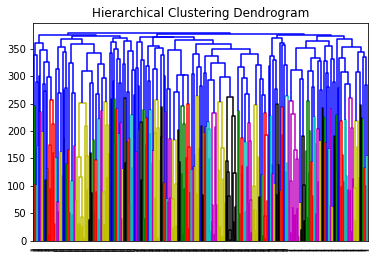

Clustering distribution: [82, 83, 135, 19, 21] [9, 7, 16, 6, 2]
Flip-One Clustering for K=5
Modified dataset by setting all labels in cluster 0 to 1
6 trusted items were incorrectly predicted. Continuing experiment...
Number of label changes made in dataset: 31
Model Accuracy w.r.t. Original dataset:  75.88235294117646
Model Accuracy w.r.t. Modified dataset:  85.0 

Modified dataset by setting all labels in cluster 0 to -1
13 trusted items were incorrectly predicted. Continuing experiment...
Number of label changes made in dataset: 51
Model Accuracy w.r.t. Original dataset:  70.29411764705883
Model Accuracy w.r.t. Modified dataset:  81.76470588235294 

Modified dataset by setting all labels in cluster 1 to 1
8 trusted items were incorrectly predicted. Continuing experiment...
Number of label changes made in dataset: 29
Model Accuracy w.r.t. Original dataset:  76.47058823529412
Model Accuracy w.r.t. Modified dataset:  84.41176470588235 

Modified dataset by setting all labels in cluster

11 trusted items were incorrectly predicted. Continuing experiment...
Number of label changes made in dataset: 9
Model Accuracy w.r.t. Original dataset:  80.58823529411765
Model Accuracy w.r.t. Modified dataset:  80.88235294117646 

Modified dataset by setting all labels in cluster 4 to 1
8 trusted items were incorrectly predicted. Continuing experiment...
Number of label changes made in dataset: 6
Model Accuracy w.r.t. Original dataset:  79.41176470588235
Model Accuracy w.r.t. Modified dataset:  80.58823529411765 

Modified dataset by setting all labels in cluster 4 to -1
8 trusted items were incorrectly predicted. Continuing experiment...
Number of label changes made in dataset: 15
Model Accuracy w.r.t. Original dataset:  80.88235294117646
Model Accuracy w.r.t. Modified dataset:  83.52941176470588 

Modified dataset by setting all labels in cluster 5 to 1
8 trusted items were incorrectly predicted. Continuing experiment...
Number of label changes made in dataset: 24
Model Accuracy w.

In [73]:
# --------------------------------------------------------------
# Experimenting with clustering

cluster_data(X_B, y_B, X_A, y_A, clf, min_K=min_K, max_K=max_K, 
             max_changes=max_changes,combo_mode=combo_mode, plot=plot, 
             cluster_with_labels=cluster_with_labels)